In [1]:
import os
import sys
import json
import argparse
from time import time
from functools import partial

import numpy as np
import pandas as pd

from tqdm import tqdm

from sklearn.preprocessing import normalize
from graspologic.cluster import GaussianCluster as GMM

from rsq.samplers import *
from rsq.samplers import _Sampler
from rsq.helpers import set_seeds

from pulearn import BaggingPuClassifier
from pulearn import ElkanotoPuClassifier

from rsq import SVCEnsemble

from joblib import Parallel, delayed

def stratified_sample(y, p=0.67, replace=False):
    unique_y, counts = np.unique(y, return_counts=True)
    n_per_class = np.array([int(np.math.floor(p*c)) for c in counts])
    n_per_class = np.array([max([npc, 1]) for npc in n_per_class])
    
    inds = np.array([np.random.choice(np.where(y == unique_y[i])[0], size=npc, replace=replace) for i, npc in enumerate(n_per_class)])
    
    return np.concatenate(inds)

In [2]:
# --
# Helpers

def subset(X, y, n):
    if isinstance(X, list):
        sel = np.random.choice(X[0].shape[0], n, replace=False)
        return [x[sel] for x in X], y[sel]
    
    sel = np.random.choice(X.shape[0], n, replace=False)
    
    return X[sel], y[sel]

def shuffle(X, y):
    """ shuffle X and y """
    
    if isinstance(X, list):
        sel = np.random.permutation(X[0].shape[0])
        return [x[sel] for x in X], y[sel]
    
    sel = np.random.permutation(X.shape[0])
    return X[sel], y[sel]

def adjust_prevalance(X, y, n_pos):
    """ adjust the prevalance of the positive class """
    
    pos_idx = np.where(y == 1)[0]
    neg_idx = np.where(y == 0)[0]
    sel = np.hstack([
        np.random.choice(pos_idx, n_pos, replace=False),
        neg_idx,
    ])
    
    if isinstance(X, list):
        return [x[sel] for x in X], y[sel]
    
    sel = np.random.permutation(sel)
    return X[sel], y[sel]


def process_data(X, y, n_pos_labels, n_all):
    X, y  = shuffle(X, y)

    X = [normalize(x, axis=1, norm='l2') for x in X]

    X, y = subset(X, y, n=n_all)

    target = np.random.choice(np.unique(y)) # !! Uniform sample class, not according to prevalance
    y      = (y == target).astype(np.int)

    X, y = adjust_prevalance(X, y, n_pos_labels)
    
    return X, y
    

def run_exp(X, y, model_idx, label_batchsize, n_label_rounds, n_queries, samplers):
    qinds       = np.random.choice(np.where(y == 1)[0], size=n_queries, replace=False)
    start_labs       = np.zeros(X[model_idx].shape[0]) - 1
    start_labs[qinds] = 1
    
    prop_pos = np.zeros((len(samplers), n_label_rounds))
    timer = np.zeros((len(samplers), n_label_rounds))
    
    for i, (sampler_name, sampler) in enumerate(samplers.items()):
        t       = time()
        if sampler_name == "MIPSampler":
            sampler = sampler(fts=X, labels=start_labs.copy())
        else:    
            sampler = sampler(fts=X[model_idx], labels=start_labs.copy())
        for j in range(n_label_rounds):

            priority  = sampler.get_priority()            # get priority of unlabeled instances
            next_idxs = priority[:label_batchsize]        # get next `query_bs` instances to label
            next_labs = y[next_idxs]                      # get labels for next instances
            sampler.set_label(next_idxs, next_labs)       # tell the sampler about the new labels
            
            prop_pos[i, j] = len(sampler.pos_idxs)
            timer[i,j] = float(time() - t)
        
    return prop_pos, timer    
            
    
def experiment(process_args, experiment_args):
    X, y = process_data(*process_args)
        
    return run_exp(X, y, *experiment_args)

In [8]:
class PUSampler(_Sampler):
    def __init__(self, fts, labels, 
                 classifier_class=SVCEnsemble, classifier_kwargs={}, 
                 bagging=True, bagging_kwargs={'n_estimators':100}
                ):
        self.fts=fts
        self.labels=labels
        
        self.classifier_class=classifier_class
        self.classifier_kwargs=classifier_kwargs
        self.model=None
        
        self.bagging=bagging
        self.bagging_kwargs=bagging_kwargs
        
        
    def get_priority(self):
        if self.model is None:
            if self.bagging:
                self.model = BaggingPuClassifier(base_estimator=self.classifier_class(**self.classifier_kwargs),
                                                 **self.bagging_kwargs
                                                )
            else:
                self.model = ElkanotoPuClassifier(estimator=classifier_class(**self.classifier_kwargs), hold_out_ratio=0.1)
                
        pos_idxs = self.pos_idxs
        neg_idxs = self.neg_idxs
        mis_idxs = self.mis_idxs
        
        temp_labels = self.labels.copy()
        temp_labels[mis_idxs] = 0
        
        self.model.fit(self.fts, temp_labels)
        scores = self.model.predict_proba(self.fts)[:, 1]
        
        mis_scores = scores[mis_idxs]
        mis_ranks  = np.argsort(1 - mis_scores)
        return mis_idxs[mis_ranks]

    def set_label(self, indices, labels):
        for i, idx in enumerate(indices):
            self.labels[idx] = labels[i]

In [9]:
classifier_class=SVCEnsemble
classifier_kwargs={'n_sup':100, 'n_semisup':100,
                   'p_inbag':0.67, 
                   'projector':'gaussian', 'projection_kwargs': {'n_components': 128}
                  }

In [10]:
# --
# Experiment parameters & initial data loading

np.random.seed(1)


data_files = ['../output/feats/crow_resnet50/birdsnap/',
#               '../output/feats/crow_wide_resnet101_2/birdsnap/',
#               '../output/feats/crow_resnext101_32x8d/birdsnap/',
#               '../output/feats/crow_vgg19/birdsnap/'
              
             ]
models = [s.split('/')[-3] for s in data_files]


X = [np.load(os.path.join(f, 'X.npy')).astype(np.float64) for f in data_files]
y = np.load(os.path.join(data_files[0], 'y.npy'))
n_pos_labels=5
n_all=5000

label_batchsize=1
n_label_rounds=10
n_queries=1
samplers = {
#     "MIPSampler"        : partial(MIPSampler, initial_max_seconds=60, update_max_seconds=30, warm_start='barycenter'),
    "PUSVCESampler"   : partial(PUSampler,
                                classifier_class=classifier_class,
                                classifier_kwargs=classifier_kwargs,
                                bagging=False
                                 ),
    "SVCSampler"        : partial(ModelSampler, model='svc'),
    "LogisticSampler"   : partial(ModelSampler, model='logistic'),
    
#     "LASSampler"        : LASSampler,
    
#     "NaiveMeanSampler"  : partial(PoolingSampler, pool_fn='mean', score_fn='pos'),
#     "RatioMeanSampler"  : partial(PoolingSampler, pool_fn='mean'),
#     "RatioMaxSampler"   : partial(PoolingSampler, pool_fn='max'),
#     "GEMSampler1"       : partial(PoolingSampler, pool_fn='gem', gem_p=1),
    "GEMSampler4"       : partial(PoolingSampler, pool_fn='gem', gem_p=4),
#     "GEMSampler16"      : partial(PoolingSampler, pool_fn='gem', gem_p=16)

}

experiment_args = (label_batchsize, n_label_rounds, n_queries, samplers)

In [11]:
np.random.seed(1)

n_cores=50
n_mc=n_cores

n_queries_ = [1]

prop_pos_1 = np.zeros((len(n_queries_), len(samplers), n_mc, n_label_rounds))
timer_1 = np.zeros((len(n_queries_), len(samplers), n_mc, n_label_rounds))

for j, n_queries in enumerate(tqdm(n_queries_)): 
    process_args = (X, y, n_pos_labels, n_all)

    experiment_args = (0, label_batchsize, n_label_rounds, n_queries, samplers)

    condensed_experiment = lambda x: experiment(process_args, experiment_args)

    props_and_timers = Parallel(n_jobs=n_cores)(delayed(condensed_experiment)(_) for _ in np.zeros(n_mc))
    temp_props = np.array([p for (p, t) in props_and_timers]) # (n_mc, len(samplers), n_label_rounds)
    temp_timers = np.array([t for (p, t) in props_and_timers])

    prop_pos_1[j] = temp_props.transpose((1,0,2))
    timer_1[j] = temp_props.transpose((1,0,2))

  0%|          | 0/1 [01:17<?, ?it/s]


AttributeError: predict_proba is not available when  probability=False

In [91]:
temp_props = np.array([p for (p, t) in props_and_timers]) # (n_mc, len(samplers), n_label_rounds)
temp_timers = np.array([t for (p, t) in props_and_timers])

prop_pos_1[j] = temp_props.transpose((1,0,2))
timer_1[j] = temp_props.transpose((1,0,2))

In [92]:
prop_pos_1.shape

(1, 4, 50, 10)

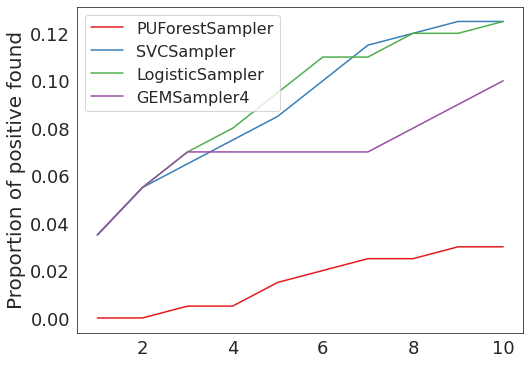

In [93]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("white")

colors = sns.color_palette("Set1", n_colors=len(samplers))


ls=['-', '--', ':', '-.']
    
k = 1000
denom = n_pos_labels - 1

mean_props = np.mean(prop_pos_1, axis=2)-1

if len(models) == 1:
    fig, ax = plt.subplots(1,1, figsize=(8,6), sharex=True, sharey=True)
else:
    fig, ax = plt.subplots(1,3, figsize=(15,5), sharex=True, sharey=True)

for i, model in enumerate(n_queries_):
    for j, sampler_name in enumerate(samplers):
        if len(models) == 1:
            ax.plot(np.arange(1, n_label_rounds+1)[:k], mean_props[i,j][:k]/denom, color=colors[j], ls=ls[i],
                       label=sampler_name)
            
            ax.legend(fontsize=16)
            ax.tick_params(labelsize=18)
            
            ax.set_ylabel('Proportion of positive found', fontsize=20)
            
        else:
            if i == 3:
                ax[i].plot(np.arange(1, n_label_rounds+1)[:k], mean_props[i,j][:k]/denom, color=colors[j], ls=ls[i],
                       label=sampler_name)
            else:
                ax[i].plot(np.arange(1, n_label_rounds+1)[:k], mean_props[i,j][:k]/denom, color=colors[j], ls=ls[i])
                
            for ax_ in ax:
                ax_.set_ylim(-0.01, 1)
                
            
            for i, model in enumerate(models):
                ax[i].set_title(model, fontsize=16) #(y=-1, c='k', label=model, ls=ls[i])

            ax[3].legend(ncol=int(np.math.floor(2)), fontsize=16, loc='upper left', bbox_to_anchor=(-2.5,1))

            fig.text(x=0.375, y=0,s='Label round (batch size = %i)'%(label_batchsize), fontsize=20)

            for i in range(len(models)):
                ax[i].tick_params(labelsize=18)

            ax[0].set_ylabel('Proportion of positive found', fontsize=20)

In [104]:
n_queries=2

np.random.seed(1)

n_cores=30
n_mc=n_cores

prop_pos_2 = np.zeros((len(models), len(samplers), n_mc, n_label_rounds))
timer_2 = np.zeros((len(models), len(samplers), n_mc, n_label_rounds))

condensed_experiment = lambda x: experiment(process_args, experiment_args)

for i, XX in enumerate(tqdm(X)):
    process_args = (X, y, n_pos_labels, n_all)
    experiment_args = (i, label_batchsize, n_label_rounds, n_queries, samplers)
    
    condensed_experiment = lambda x: experiment(process_args, experiment_args)
    
    props_and_timers = Parallel(n_jobs=n_cores)(delayed(condensed_experiment)(_) for _ in np.zeros(n_mc))
    temp_props = np.array([p for (p, t) in props_and_timers]) # (n_mc, len(samplers), n_label_rounds)
    temp_timers = np.array([t for (p, t) in props_and_timers])
    
    prop_pos_2[i] = temp_props.transpose((1,0,2))
    timer_2[i] = temp_props.transpose((1,0,2))

100%|██████████| 4/4 [40:21<00:00, 605.35s/it]


Text(0, 0.5, 'Proportion of positive found')

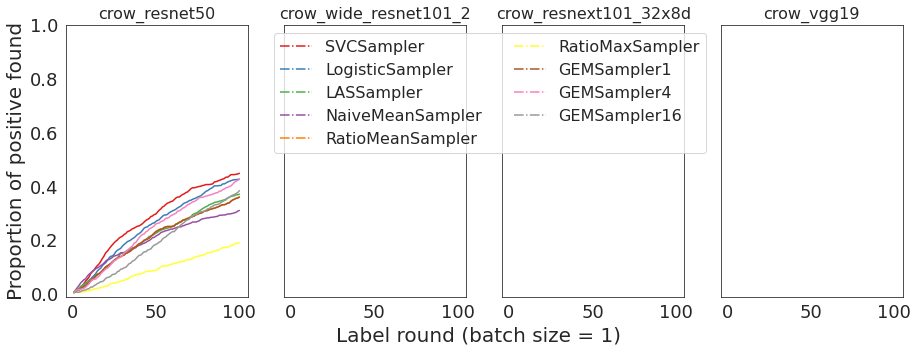

In [103]:
# import matplotlib.pyplot as plt
# import seaborn as sns
# sns.set_style("white")

# colors = sns.color_palette("Set1", n_colors=len(samplers))


# ls=['-', '--', ':', '-.']
# fig, ax = plt.subplots(1,4, figsize=(15,5), sharex=True, sharey=True)

# for i, model in enumerate(models):
#     ax[i].set_title(model, fontsize=16) #(y=-1, c='k', label=model, ls=ls[i])
    
# k = 1000
# denom = n_pos_labels - 2

# mean_props = np.mean(prop_pos_2, axis=2)-2
# for i, model in enumerate(models):
#     for j, sampler_name in enumerate(samplers):
#         if i == 3:
#             ax[i].plot(np.arange(1, n_label_rounds+1)[:k], mean_props[i,j][:k]/denom, color=colors[j], ls=ls[i],
#                    label=sampler_name)
#         else:
#             ax[i].plot(np.arange(1, n_label_rounds+1)[:k], mean_props[i,j][:k]/denom, color=colors[j], ls=ls[i])


            
# for ax_ in ax:
#     ax_.set_ylim(-0.01, 1)

# ax[3].legend(ncol=int(np.math.floor(2)), fontsize=16, loc='upper left', bbox_to_anchor=(-2.5,1))

# fig.text(x=0.375, y=0,s='Label round (batch size = %i)'%(label_batchsize), fontsize=20)

# for i in range(len(models)):
#     ax[i].tick_params(labelsize=18)

ax[0].set_ylabel('Proportion of positive found', fontsize=20)

In [16]:
n_queries=5

np.random.seed(1)

n_cores=12
n_mc=4*n_cores

prop_pos_5 = np.zeros((len(models), len(samplers), n_mc, n_label_rounds))
timer_5 = np.zeros((len(models), len(samplers), n_mc, n_label_rounds))

condensed_experiment = lambda x: experiment(process_args, experiment_args)

for i, XX in enumerate(tqdm(X)):
    process_args = (X, y, n_pos_labels, n_all)
    experiment_args = (i, label_batchsize, n_label_rounds, n_queries, samplers)
    
    condensed_experiment = lambda x: experiment(process_args, experiment_args)
    
    props_and_timers = Parallel(n_jobs=n_cores)(delayed(condensed_experiment)(_) for _ in np.zeros(n_mc))
    temp_props = np.array([p for (p, t) in props_and_timers]) # (n_mc, len(samplers), n_label_rounds)
    temp_timers = np.array([t for (p, t) in props_and_timers])
    
    prop_pos_5[i] = temp_props.transpose((1,0,2))
    timer_5[i] = temp_props.transpose((1,0,2))

100%|██████████| 4/4 [1:40:15<00:00, 1503.79s/it]  


Text(0, 0.5, 'Proportion of positive found')

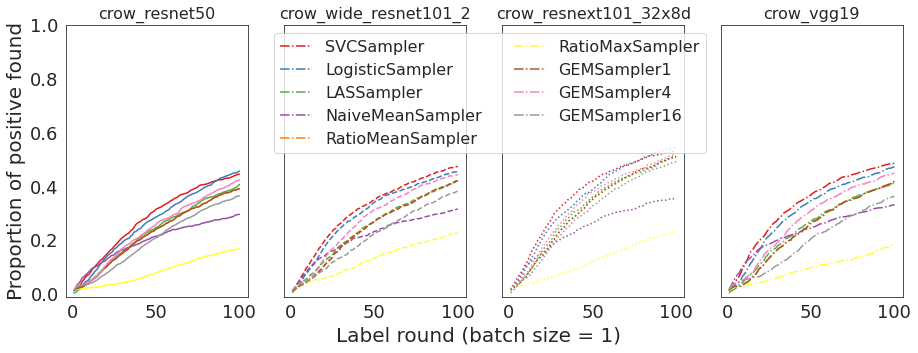

In [68]:
# import matplotlib.pyplot as plt
# import seaborn as sns
# sns.set_style("white")

# colors = sns.color_palette("Set1", n_colors=len(samplers))


# ls=['-', '--', ':', '-.']
# fig, ax = plt.subplots(1,4, figsize=(15,5), sharex=True, sharey=True)

# for i, model in enumerate(models):
#     ax[i].set_title(model, fontsize=16) #(y=-1, c='k', label=model, ls=ls[i])
    
# k = 1000
# denom = n_pos_labels - 5

# mean_props = np.mean(prop_pos_5, axis=2)-5
# for i, model in enumerate(models):
#     for j, sampler_name in enumerate(samplers):
#         if i == 3:
#             ax[i].plot(np.arange(1, n_label_rounds+1)[:k], mean_props[i,j][:k]/denom, color=colors[j], ls=ls[i],
#                    label=sampler_name)
#         else:
#             ax[i].plot(np.arange(1, n_label_rounds+1)[:k], mean_props[i,j][:k]/denom, color=colors[j], ls=ls[i])


            
# for ax_ in ax:
#     ax_.set_ylim(-0.01, 1)

# ax[3].legend(ncol=int(np.math.floor(2)), fontsize=16, loc='upper left', bbox_to_anchor=(-2.5,1))

# fig.text(x=0.375, y=0,s='Label round (batch size = %i)'%(label_batchsize), fontsize=20)

# for i in range(len(models)):
#     ax[i].tick_params(labelsize=18)

ax[0].set_ylabel('Proportion of positive found', fontsize=20)

In [17]:
n_queries=8

np.random.seed(1)

n_cores=12
n_mc=4*n_cores

prop_pos_8 = np.zeros((len(models), len(samplers), n_mc, n_label_rounds))
timer_8 = np.zeros((len(models), len(samplers), n_mc, n_label_rounds))

condensed_experiment = lambda x: experiment(process_args, experiment_args)

for i, XX in enumerate(tqdm(X)):
    process_args = (X, y, n_pos_labels, n_all)
    experiment_args = (i, label_batchsize, n_label_rounds, n_queries, samplers)
    
    condensed_experiment = lambda x: experiment(process_args, experiment_args)
    
    props_and_timers = Parallel(n_jobs=n_cores)(delayed(condensed_experiment)(_) for _ in np.zeros(n_mc))
    temp_props = np.array([p for (p, t) in props_and_timers]) # (n_mc, len(samplers), n_label_rounds)
    temp_timers = np.array([t for (p, t) in props_and_timers])
    
    prop_pos_8[i] = temp_props.transpose((1,0,2))
    timer_8[i] = temp_props.transpose((1,0,2))

100%|██████████| 4/4 [1:48:05<00:00, 1621.41s/it]  


Text(0, 0.5, 'Proportion of positive found')

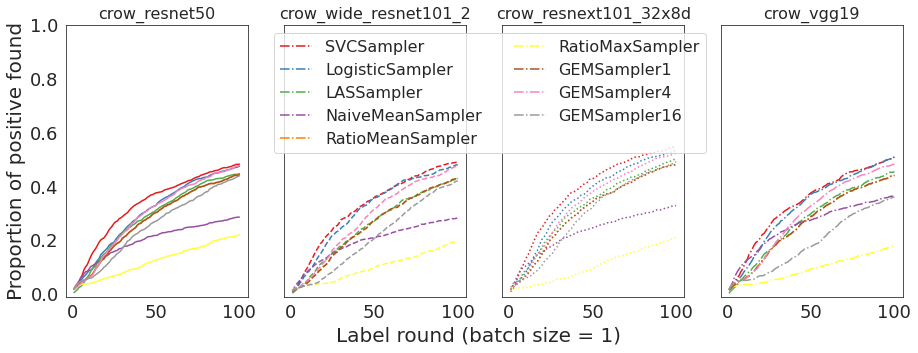

In [67]:
# import matplotlib.pyplot as plt
# import seaborn as sns
# sns.set_style("white")

# colors = sns.color_palette("Set1", n_colors=len(samplers))


# ls=['-', '--', ':', '-.']
# fig, ax = plt.subplots(1,4, figsize=(15,5), sharex=True, sharey=True)

# for i, model in enumerate(models):
#     ax[i].set_title(model, fontsize=16) #(y=-1, c='k', label=model, ls=ls[i])
    
# k = 1000
# denom = n_pos_labels - 8

# mean_props = np.mean(prop_pos_8, axis=2)-8
# for i, model in enumerate(models):
#     for j, sampler_name in enumerate(samplers):
#         if i == 3:
#             ax[i].plot(np.arange(1, n_label_rounds+1)[:k], mean_props[i,j][:k]/denom, color=colors[j], ls=ls[i],
#                    label=sampler_name)
#         else:
#             ax[i].plot(np.arange(1, n_label_rounds+1)[:k], mean_props[i,j][:k]/denom, color=colors[j], ls=ls[i])


            
# for ax_ in ax:
#     ax_.set_ylim(-0.01, 1)

# ax[3].legend(ncol=int(np.math.floor(2)), fontsize=16, loc='upper left', bbox_to_anchor=(-2.5,1))

# fig.text(x=0.375, y=0,s='Label round (batch size = %i)'%(label_batchsize), fontsize=20)

# for i in range(len(models)):
#     ax[i].tick_params(labelsize=18)

ax[0].set_ylabel('Proportion of positive found', fontsize=20)

Text(108.125, 0.5, 'Proportion of positive found')

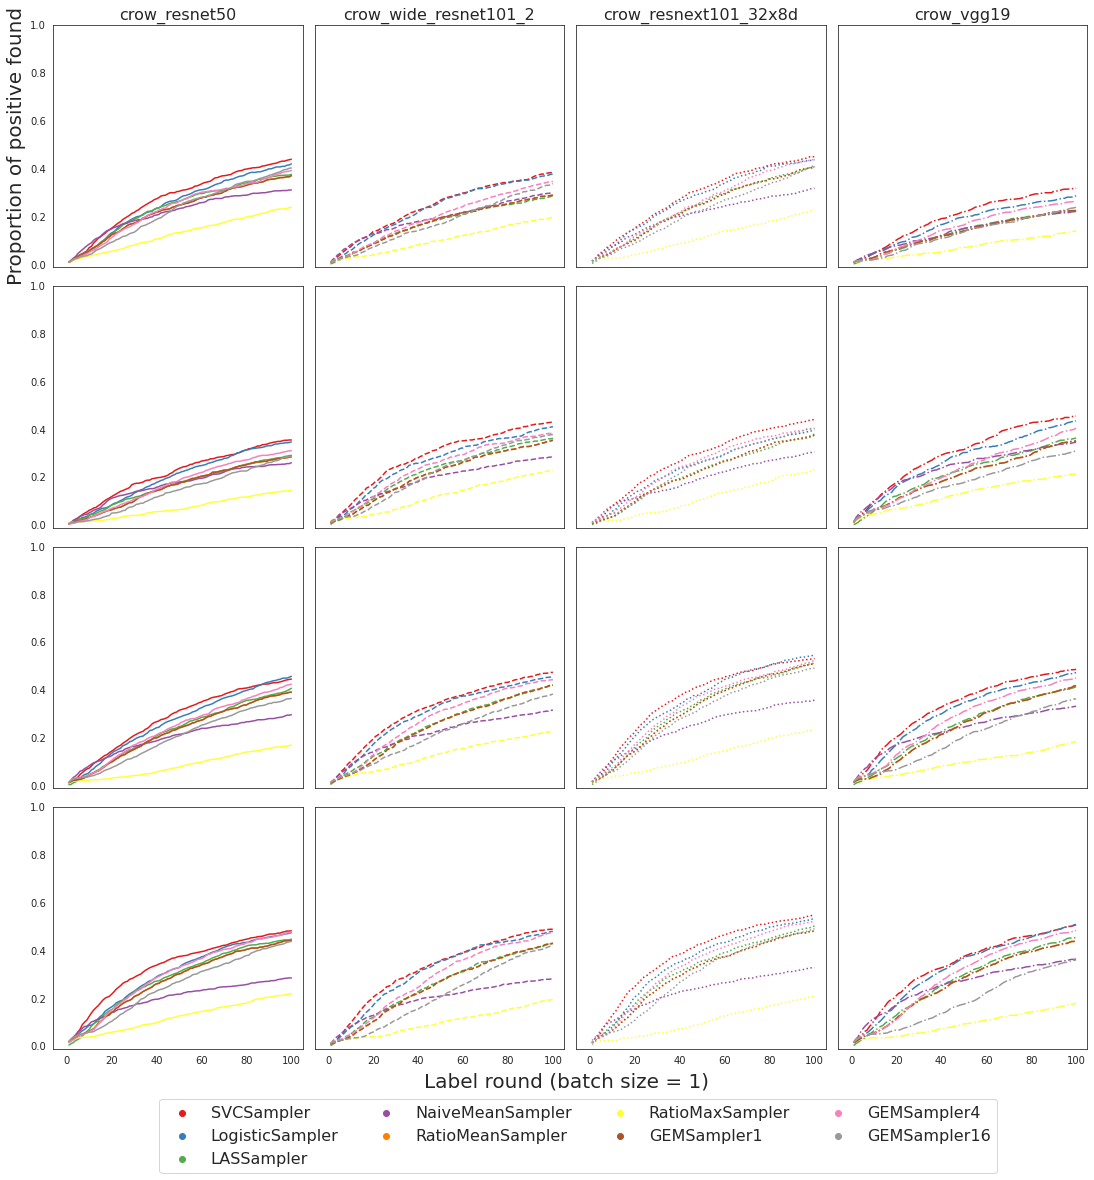

In [110]:
results = [prop_pos_1, prop_pos_2, prop_pos_5, prop_pos_8]
n_queries = [1,2,5,8]

colors = sns.color_palette("Set1", n_colors=len(samplers))


ls=['-', '--', ':', '-.']
fig, ax = plt.subplots(len(results),4, figsize=(15,15), sharex=True, sharey=True)

for i, prop_pos in enumerate(results):
    

    for j, model in enumerate(models):
        ax[0, j].set_title(model, fontsize=16) #(y=-1, c='k', label=model, ls=ls[i])

    to = 1000
    denom = n_pos_labels - n_queries[i]

    mean_props = np.mean(prop_pos, axis=2)-n_queries[i]
    for j, model in enumerate(models):
        for k, sampler_name in enumerate(samplers):
            if i == len(results)-1 and j==len(models)-1:
                ax[i,j].scatter(-1, -1, color=colors[k], label=sampler_name)
                
            
            ax[i,j].plot(np.arange(1, n_label_rounds+1)[:to], mean_props[j,k][:to]/denom, color=colors[k], ls=ls[j])



# for ax_ in ax:
ax[0,0].set_ylim(-0.01, 1)

plt.tight_layout()

ax[len(results)-1,len(models)-1].legend(ncol=int(len(samplers)/2), fontsize=16, loc='upper left', bbox_to_anchor=(-2.75,-0.175))

fig.text(x=0.375, y=-0.01,s='Label round (batch size = %i)'%(label_batchsize), fontsize=20)

# for i in range(len(models)):
#     ax[i].tick_params(labelsize=18)

ax[0,0].set_ylabel('Proportion of positive found', fontsize=20)

In [109]:
np.mean(prop_pos_2, axis=-2)[0,0] / denom

array([0.07738095, 0.08095238, 0.09166667, 0.09642857, 0.10119048,
       0.10833333, 0.11547619, 0.12142857, 0.12619048, 0.13333333,
       0.13690476, 0.14285714, 0.1452381 , 0.15238095, 0.15833333,
       0.16666667, 0.17380952, 0.1797619 , 0.18452381, 0.19047619,
       0.19642857, 0.20119048, 0.20714286, 0.21309524, 0.21547619,
       0.2202381 , 0.22380952, 0.22857143, 0.24047619, 0.24404762,
       0.24642857, 0.24642857, 0.24880952, 0.25119048, 0.25714286,
       0.25952381, 0.25952381, 0.26547619, 0.26666667, 0.26904762,
       0.2702381 , 0.27142857, 0.27380952, 0.27619048, 0.2797619 ,
       0.28690476, 0.29047619, 0.29880952, 0.30357143, 0.30833333,
       0.31190476, 0.31547619, 0.31666667, 0.3202381 , 0.325     ,
       0.32619048, 0.33095238, 0.33333333, 0.33452381, 0.33928571,
       0.34047619, 0.34285714, 0.34404762, 0.34880952, 0.34880952,
       0.35119048, 0.3547619 , 0.35595238, 0.35714286, 0.35833333,
       0.36190476, 0.36309524, 0.36547619, 0.36666667, 0.36785